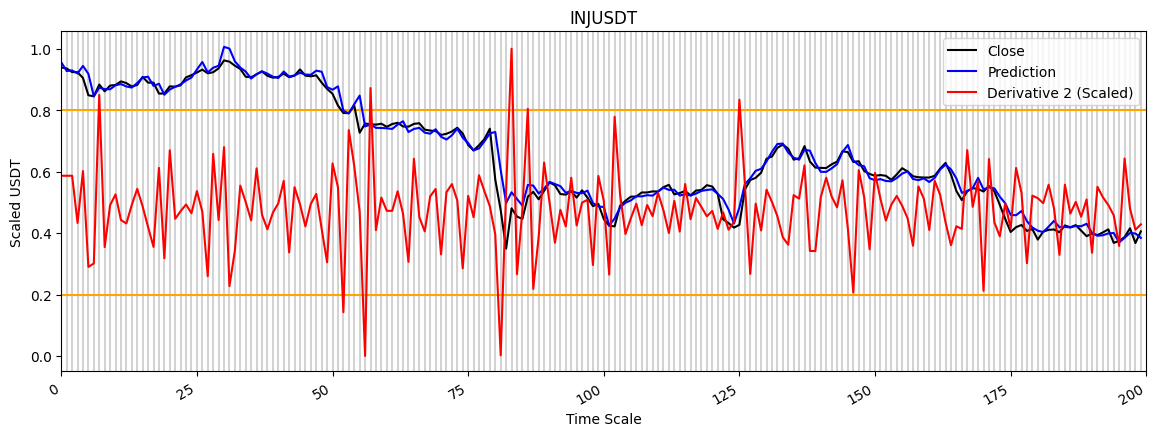

ValueError: attempt to get argmax of an empty sequence

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
import keras 
import datetime as dt
import pandas_ta as ta
import util as ut
import constantes as cons
symbol =  str.upper('inj'+'USDT')

#obtiene la data
X_train,y_train,X_test,y_test,data=ut.obtiene_historial(symbol)

#carga el modelo guardado y predice
lstm = keras.models.load_model('modelos/lstm'+symbol+'.h5')
y_pred = lstm.predict(X_test,verbose = 0)

deriv_y_pred = np.diff(y_pred, axis=0)
deriv_y_pred2 = np.diff(deriv_y_pred, axis=0)
deriv_y_pred = deriv_y_pred.reshape(-1, 1)
deriv_y_pred2 = deriv_y_pred2.reshape(-1, 1)
# Escalar las derivadas
scaler1 = MinMaxScaler(feature_range=(0, 1))
deriv_y_pred_scaled = scaler1.fit_transform(deriv_y_pred)
scaler2 = MinMaxScaler(feature_range=(0, 1))
deriv_y_pred_scaled2 = scaler2.fit_transform(deriv_y_pred2)
deriv_y_pred_scaled = np.insert(deriv_y_pred_scaled, 0, deriv_y_pred_scaled[0], axis=0)#para mover 1 posicion hacia adelante
deriv_y_pred_scaled2 = np.insert(deriv_y_pred_scaled2, 0, deriv_y_pred_scaled2[0], axis=0)#para mover 1 posicion hacia adelante
deriv_y_pred_scaled2 = np.insert(deriv_y_pred_scaled2, 0, deriv_y_pred_scaled2[0], axis=0)#para mover 1 posicion hacia adelante

#grafica

plt.figure(figsize=(14, 5))
time_index = range(cons.n_steps-1, cons.n_steps-1+len(y_pred))
# Agregar líneas verticales
for i in time_index:
    plt.axvline(x=i, color='lightgray')
plt.xlim(0,len(y_test))
plt.axhline(y = cons.umbralalto, color = 'orange', linestyle = '-')
plt.axhline(y = cons.umbralbajo, color = 'orange', linestyle = '-')
plt.plot(y_test, label='Close',color = 'black')
plt.plot( y_pred[:, -1, 0], label='Prediction',color = 'blue')
#plt.plot(deriv_y_pred_scaled, label='Derivative 1 (Scaled)',color = 'blue')
plt.plot( deriv_y_pred_scaled2, label='Derivative 2 (Scaled)', color='red')
#plt.plot( ema_deriv, label='Ema Derivative 1 (Scaled)', color='green')
#plt.plot( ema_deriv2, label='Ema Derivative 2 (Scaled)', color='orange')
plt.xlabel('Time Scale')
plt.ylabel('Scaled USDT')
plt.legend()
plt.gcf().autofmt_xdate()
plt.title(symbol)
#plt.grid()
plt.show()

data['ema20']=data.ta.ema(20)
data['ema50']=data.ta.ema(50)
data['ema200']=data.ta.ema(200)
data['atr']=ta.atr(data.High, data.Low, data.Close)
data=data.tail(200)
data_copy = data.copy()
data_copy['deriv'] = deriv_y_pred_scaled2
data=data_copy

from backtesting import Backtest, Strategy

def funcion_mismo_valor(self,data):
    return np.array(data)

class Predictor2(Strategy):
    def init(self):

        self.ema20 = self.I(ta.ema, pd.Series(self.data.Close),20, color='green')
        self.ema50 = self.I(ta.ema, pd.Series(self.data.Close),50, color='yellow')
        self.ema200= self.I(funcion_mismo_valor, (self.data.ema200),None,color='grey')

    def next(self):
        if self.position:
            pass
        else:
            if self.data.Close[-1] > self.data.ema20[-1] > self.data.ema50[-1] > self.data.ema200[-1] and self.data.deriv[-1] >= cons.umbralalto and self.data.deriv[-2] > cons.umbralbajo:
                self.buy(size=1000, sl=self.data.ema200[-1] , tp=self.data.Close[-1] + self.data.atr[-1])
            elif self.data.Close[-1] < self.data.ema20[-1] < self.data.ema50[-1] < self.data.ema200[-1] and self.data.deriv[-1] <= cons.umbralbajo and self.data.deriv[-2] < cons.umbralalto:
                self.sell(size=1000, sl=self.data.ema200[-1] , tp=self.data.Close[-1] - self.data.atr[-1])

bt = Backtest(data, Predictor2,
              cash=1000, commission=.002,
              exclusive_orders=True)

output = bt.run()
bt.plot()
output
